In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised
# from attention import Attention

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [3]:
dataset = pd.read_csv('../../data//pollution.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,pollution,dew,temp,press,wnd_spd,snow,rain,NE,NW,SE,cv
date,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,231.97,0,0,0,1,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,237.78,0,0,0,1,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,242.70,0,0,0,1,0,0


In [4]:
print(dataset.columns)

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE',
       'NW', 'SE', 'cv'],
      dtype='object')


In [5]:
# specify the number of lag hours
n_hours = 24*3
K = 6

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [6]:
# Pre-processing
stages = dataset[['pollution']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (43800, 1)
stages_supervised.shape: (43723, 78)


In [7]:
stages_supervised

,var1(t-72),var1(t-71),var1(t-70),var1(t-69),var1(t-68),var1(t-67),var1(t-66),var1(t-65),var1(t-64),var1(t-63),...,var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5)
date,,,,,,,,,,,,,,,,,,,,,
2010-01-05 00:00:00,129.0,148.0,159.0,181.0,138.0,109.0,105.0,124.0,120.0,132.0,...,31.0,33.0,29.0,31.0,30.0,34.0,27.0,25.0,28.0,28.0
2010-01-05 01:00:00,148.0,159.0,181.0,138.0,109.0,105.0,124.0,120.0,132.0,140.0,...,33.0,29.0,31.0,30.0,34.0,27.0,25.0,28.0,28.0,27.0
2010-01-05 02:00:00,159.0,181.0,138.0,109.0,105.0,124.0,120.0,132.0,140.0,152.0,...,29.0,31.0,30.0,34.0,27.0,25.0,28.0,28.0,27.0,27.0
2010-01-05 03:00:00,181.0,138.0,109.0,105.0,124.0,120.0,132.0,140.0,152.0,148.0,...,31.0,30.0,34.0,27.0,25.0,28.0,28.0,27.0,27.0,27.0
2010-01-05 04:00:00,138.0,109.0,105.0,124.0,120.0,132.0,140.0,152.0,148.0,164.0,...,30.0,34.0,27.0,25.0,28.0,28.0,27.0,27.0,27.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 14:00:00,32.0,33.0,45.0,42.0,41.0,110.0,175.0,293.0,324.0,341.0,...,7.0,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0
2014-12-31 15:00:00,33.0,45.0,42.0,41.0,110.0,175.0,293.0,324.0,341.0,362.0,...,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0
2014-12-31 16:00:00,45.0,42.0,41.0,110.0,175.0,293.0,324.0,341.0,362.0,372.0,...,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0,10.0


#### Prior unknown covariates (6)

In [8]:
# prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
# print("prior_unknown.shape:", prior_unknown.shape)

# prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, K)
# print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

In [9]:
# prior_unknown_supervised

#### Prior known covariates (9)

In [10]:
prior_known = dataset[['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE', 'NW', 'SE', 'cv']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, K)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (43800, 10)
prior_known_supervised.shape: (43723, 780)


In [11]:
# prior_known_supervised

### N_out, N_in, K

In [12]:
past_cov = dataset[['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE', 'NW', 'SE', 'cv']]

past_cov_supervised = series_to_supervised(past_cov, n_hours, K)
print("past_cov_supervised.shape:", past_cov_supervised.shape)

past_cov_supervised.shape: (43723, 780)


In [13]:
# past_cov_supervised  # 6 + 9 = 15 features

In [14]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [15]:
# past_ws_supervised  # 4

In [16]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*past_cov.shape[1]:(i+1)*past_cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [17]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised, past_ws_supervised], axis=1)
past_cov_ws_supervised = past_cov_ws_supervised[columns]


In [18]:
# past_cov_ws_supervised

In [19]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, K*prior_known.shape[1]:]  # shift 2 days for prior known covariates
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-66),shift_prior_known_supervised_var2(t-66),shift_prior_known_supervised_var3(t-66),shift_prior_known_supervised_var4(t-66),shift_prior_known_supervised_var5(t-66),shift_prior_known_supervised_var6(t-66),shift_prior_known_supervised_var7(t-66),shift_prior_known_supervised_var8(t-66),shift_prior_known_supervised_var9(t-66),shift_prior_known_supervised_var10(t-66),...,shift_prior_known_supervised_var1(t+5),shift_prior_known_supervised_var2(t+5),shift_prior_known_supervised_var3(t+5),shift_prior_known_supervised_var4(t+5),shift_prior_known_supervised_var5(t+5),shift_prior_known_supervised_var6(t+5),shift_prior_known_supervised_var7(t+5),shift_prior_known_supervised_var8(t+5),shift_prior_known_supervised_var9(t+5),shift_prior_known_supervised_var10(t+5)
0,-7.0,-6.0,1023.0,8.93,4.0,0.0,0.0,0.0,1.0,0.0,...,-27.0,-16.0,1034.0,4.92,0.0,0.0,1.0,0.0,0.0,0.0
1,-7.0,-5.0,1024.0,10.72,0.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-16.0,1035.0,8.05,0.0,0.0,1.0,0.0,0.0,0.0
2,-8.0,-6.0,1024.0,12.51,0.0,0.0,0.0,0.0,1.0,0.0,...,-27.0,-16.0,1034.0,13.86,0.0,0.0,1.0,0.0,0.0,0.0
3,-7.0,-5.0,1025.0,14.30,0.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-16.0,1035.0,18.78,0.0,0.0,1.0,0.0,0.0,0.0
4,-7.0,-5.0,1026.0,17.43,1.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-15.0,1035.0,24.59,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43718,-13.0,3.0,1017.0,0.89,0.0,0.0,0.0,0.0,0.0,1.0,...,-23.0,-2.0,1034.0,231.97,0.0,0.0,0.0,1.0,0.0,0.0
43719,-13.0,1.0,1017.0,1.78,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-3.0,1034.0,237.78,0.0,0.0,0.0,1.0,0.0,0.0
43720,-10.0,2.0,1017.0,2.67,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-3.0,1034.0,242.70,0.0,0.0,0.0,1.0,0.0,0.0
43721,-10.0,-2.0,1017.0,3.12,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-4.0,1034.0,246.72,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
shift_prior_known_past_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], 
                                                     axis=1)


In [21]:
# shift_prior_known_past_cov_ws_supervised

In [22]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5)
0,30.0,34.0,27.0,25.0,28.0,28.0
1,34.0,27.0,25.0,28.0,28.0,27.0
2,27.0,25.0,28.0,28.0,27.0,27.0
3,25.0,28.0,28.0,27.0,27.0,27.0
4,28.0,28.0,27.0,27.0,27.0,29.0
...,...,...,...,...,...,...
43718,9.0,11.0,8.0,9.0,10.0,8.0
43719,11.0,8.0,9.0,10.0,8.0,10.0
43720,8.0,9.0,10.0,8.0,10.0,10.0
43721,9.0,10.0,8.0,10.0,10.0,8.0


### Concatenation

In [23]:
all_data = concat([shift_prior_known_past_cov_ws_supervised, future_ws_supervised], axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (43723, 1518)


### Train & Test set

In [24]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 34978


In [25]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

1512

### Normalization

In [26]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (34978, 1512) (34978, 6) (8745, 1512) (8745, 6)


In [27]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (34978, 72, 21) (34978, 6) (8745, 72, 21) (8745, 6)


### Model

In [28]:
model_input = Input(shape=(train_X.shape[1], train_X.shape[2]))
x = layers.SimpleRNN(208, 
                     activation='relu', 
                     kernel_regularizer=keras.regularizers.L1L2(l1=0, l2=1e-5),
                     recurrent_regularizer=keras.regularizers.L1L2(l1=0, l2=1e-5),
                     return_sequences=True)(model_input)
x = layers.Flatten()(x)
# x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-4))(x)
# x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-4, l2=1e-5))(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=0, l2=1e-5))(x)

output = layers.Dense(train_y.shape[1])(x)

model_rnn = Model(model_input, output)
model_rnn.summary()

2022-11-26 00:41:40.685808: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-11-26 00:41:40.739924: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:88:00.0 name: NVIDIA TITAN X (Pascal) computeCapability: 6.1
coreClock: 1.531GHz coreCount: 28 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 447.48GiB/s
2022-11-26 00:41:40.740674: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-11-26 00:41:40.744167: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-11-26 00:41:40.747255: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-11-26 00:41:40.748148: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuran

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 72, 21)]          0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 72, 208)           47840     
_________________________________________________________________
flatten (Flatten)            (None, 14976)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                958528    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 1,006,758
Trainable params: 1,006,758
Non-trainable params: 0
_________________________________________________________________


Epoch 1/3000


2022-11-26 00:41:43.665327: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10



Epoch 00001: val_mae improved from inf to 0.10276, saving model to saved_model/rnn_shift_anyday_6h_cp6.h5
69/69 - 3s - loss: 0.0195 - mae: 0.0947 - val_loss: 0.0259 - val_mae: 0.1028
Epoch 2/3000

Epoch 00002: val_mae improved from 0.10276 to 0.09532, saving model to saved_model/rnn_shift_anyday_6h_cp6.h5
69/69 - 3s - loss: 0.0122 - mae: 0.0659 - val_loss: 0.0229 - val_mae: 0.0953
Epoch 3/3000

Epoch 00003: val_mae improved from 0.09532 to 0.08199, saving model to saved_model/rnn_shift_anyday_6h_cp6.h5
69/69 - 3s - loss: 0.0114 - mae: 0.0631 - val_loss: 0.0182 - val_mae: 0.0820
Epoch 4/3000

Epoch 00004: val_mae improved from 0.08199 to 0.07793, saving model to saved_model/rnn_shift_anyday_6h_cp6.h5
69/69 - 3s - loss: 0.0104 - mae: 0.0590 - val_loss: 0.0168 - val_mae: 0.0779
Epoch 5/3000

Epoch 00005: val_mae improved from 0.07793 to 0.07517, saving model to saved_model/rnn_shift_anyday_6h_cp6.h5
69/69 - 3s - loss: 0.0101 - mae: 0.0580 - val_loss: 0.0152 - val_mae: 0.0752
Epoch 6/3000

Epoch 51/3000

Epoch 00051: val_mae did not improve from 0.04749
69/69 - 3s - loss: 0.0049 - mae: 0.0352 - val_loss: 0.0086 - val_mae: 0.0535
Epoch 52/3000

Epoch 00052: val_mae did not improve from 0.04749
69/69 - 3s - loss: 0.0057 - mae: 0.0415 - val_loss: 0.0078 - val_mae: 0.0514
Epoch 53/3000

Epoch 00053: val_mae did not improve from 0.04749
69/69 - 3s - loss: 0.0047 - mae: 0.0339 - val_loss: 0.0074 - val_mae: 0.0482
Epoch 54/3000

Epoch 00054: val_mae improved from 0.04749 to 0.04523, saving model to saved_model/rnn_shift_anyday_6h_cp6.h5
69/69 - 3s - loss: 0.0046 - mae: 0.0329 - val_loss: 0.0072 - val_mae: 0.0452
Epoch 55/3000

Epoch 00055: val_mae did not improve from 0.04523
69/69 - 3s - loss: 0.0045 - mae: 0.0323 - val_loss: 0.0076 - val_mae: 0.0478
Epoch 56/3000

Epoch 00056: val_mae did not improve from 0.04523
69/69 - 3s - loss: 0.0050 - mae: 0.0376 - val_loss: 0.0082 - val_mae: 0.0573
Epoch 57/3000

Epoch 00057: val_mae did not improve from 0.04523
69/69 - 3s - loss: 0.00

Epoch 107/3000

Epoch 00107: val_mae did not improve from 0.04319
69/69 - 3s - loss: 0.0036 - mae: 0.0332 - val_loss: 0.0061 - val_mae: 0.0470
Epoch 108/3000

Epoch 00108: val_mae improved from 0.04319 to 0.04296, saving model to saved_model/rnn_shift_anyday_6h_cp6.h5
69/69 - 3s - loss: 0.0035 - mae: 0.0314 - val_loss: 0.0059 - val_mae: 0.0430
Epoch 109/3000

Epoch 00109: val_mae did not improve from 0.04296
69/69 - 3s - loss: 0.0033 - mae: 0.0297 - val_loss: 0.0063 - val_mae: 0.0452
Epoch 110/3000

Epoch 00110: val_mae did not improve from 0.04296
69/69 - 3s - loss: 0.0034 - mae: 0.0317 - val_loss: 0.0060 - val_mae: 0.0465
Epoch 111/3000

Epoch 00111: val_mae did not improve from 0.04296
69/69 - 3s - loss: 0.0034 - mae: 0.0312 - val_loss: 0.0059 - val_mae: 0.0433
Epoch 112/3000

Epoch 00112: val_mae did not improve from 0.04296
69/69 - 3s - loss: 0.0032 - mae: 0.0299 - val_loss: 0.0062 - val_mae: 0.0450
Epoch 113/3000

Epoch 00113: val_mae did not improve from 0.04296
69/69 - 3s - los

Epoch 162/3000

Epoch 00162: val_mae did not improve from 0.03965
69/69 - 3s - loss: 0.0028 - mae: 0.0291 - val_loss: 0.0051 - val_mae: 0.0407
Epoch 163/3000

Epoch 00163: val_mae did not improve from 0.03965
69/69 - 3s - loss: 0.0026 - mae: 0.0278 - val_loss: 0.0054 - val_mae: 0.0427
Epoch 164/3000

Epoch 00164: val_mae did not improve from 0.03965
69/69 - 3s - loss: 0.0026 - mae: 0.0284 - val_loss: 0.0050 - val_mae: 0.0416
Epoch 165/3000

Epoch 00165: val_mae did not improve from 0.03965
69/69 - 3s - loss: 0.0027 - mae: 0.0286 - val_loss: 0.0052 - val_mae: 0.0426
Epoch 166/3000

Epoch 00166: val_mae did not improve from 0.03965
69/69 - 3s - loss: 0.0027 - mae: 0.0292 - val_loss: 0.0056 - val_mae: 0.0440
Epoch 167/3000

Epoch 00167: val_mae did not improve from 0.03965
69/69 - 3s - loss: 0.0029 - mae: 0.0311 - val_loss: 0.0054 - val_mae: 0.0437
Epoch 168/3000

Epoch 00168: val_mae did not improve from 0.03965
69/69 - 3s - loss: 0.0028 - mae: 0.0292 - val_loss: 0.0051 - val_mae: 0.0407

Epoch 220/3000

Epoch 00220: val_mae did not improve from 0.03965
69/69 - 3s - loss: 0.0023 - mae: 0.0273 - val_loss: 0.0051 - val_mae: 0.0420
Epoch 221/3000

Epoch 00221: val_mae did not improve from 0.03965
69/69 - 3s - loss: 0.0024 - mae: 0.0278 - val_loss: 0.0047 - val_mae: 0.0404
Epoch 222/3000

Epoch 00222: val_mae did not improve from 0.03965
69/69 - 3s - loss: 0.0024 - mae: 0.0273 - val_loss: 0.0048 - val_mae: 0.0403
Epoch 223/3000

Epoch 00223: val_mae did not improve from 0.03965
69/69 - 3s - loss: 0.0023 - mae: 0.0273 - val_loss: 0.0051 - val_mae: 0.0421
Epoch 224/3000

Epoch 00224: val_mae did not improve from 0.03965
69/69 - 3s - loss: 0.0024 - mae: 0.0278 - val_loss: 0.0047 - val_mae: 0.0404
Epoch 225/3000

Epoch 00225: val_mae did not improve from 0.03965
69/69 - 3s - loss: 0.0024 - mae: 0.0272 - val_loss: 0.0047 - val_mae: 0.0403
Epoch 226/3000

Epoch 00226: val_mae did not improve from 0.03965
69/69 - 3s - loss: 0.0023 - mae: 0.0273 - val_loss: 0.0051 - val_mae: 0.0419

Epoch 277/3000

Epoch 00277: val_mae did not improve from 0.03956
69/69 - 3s - loss: 0.0022 - mae: 0.0266 - val_loss: 0.0049 - val_mae: 0.0413
Epoch 278/3000

Epoch 00278: val_mae did not improve from 0.03956
69/69 - 3s - loss: 0.0022 - mae: 0.0268 - val_loss: 0.0046 - val_mae: 0.0398
Epoch 279/3000

Epoch 00279: val_mae improved from 0.03956 to 0.03941, saving model to saved_model/rnn_shift_anyday_6h_cp6.h5
69/69 - 3s - loss: 0.0022 - mae: 0.0264 - val_loss: 0.0046 - val_mae: 0.0394
Epoch 280/3000

Epoch 00280: val_mae did not improve from 0.03941
69/69 - 3s - loss: 0.0022 - mae: 0.0265 - val_loss: 0.0048 - val_mae: 0.0412
Epoch 281/3000

Epoch 00281: val_mae did not improve from 0.03941
69/69 - 3s - loss: 0.0022 - mae: 0.0267 - val_loss: 0.0046 - val_mae: 0.0399
Epoch 282/3000

Epoch 00282: val_mae did not improve from 0.03941
69/69 - 3s - loss: 0.0022 - mae: 0.0264 - val_loss: 0.0046 - val_mae: 0.0394
Epoch 283/3000

Epoch 00283: val_mae did not improve from 0.03941
69/69 - 3s - los

Epoch 331/3000

Epoch 00331: val_mae did not improve from 0.03909
69/69 - 3s - loss: 0.0021 - mae: 0.0261 - val_loss: 0.0047 - val_mae: 0.0407
Epoch 332/3000

Epoch 00332: val_mae did not improve from 0.03909
69/69 - 3s - loss: 0.0021 - mae: 0.0262 - val_loss: 0.0045 - val_mae: 0.0396
Epoch 333/3000

Epoch 00333: val_mae did not improve from 0.03909
69/69 - 3s - loss: 0.0021 - mae: 0.0259 - val_loss: 0.0045 - val_mae: 0.0392
Epoch 334/3000

Epoch 00334: val_mae did not improve from 0.03909
69/69 - 3s - loss: 0.0021 - mae: 0.0261 - val_loss: 0.0047 - val_mae: 0.0407
Epoch 335/3000

Epoch 00335: val_mae did not improve from 0.03909
69/69 - 3s - loss: 0.0021 - mae: 0.0260 - val_loss: 0.0044 - val_mae: 0.0393
Epoch 336/3000

Epoch 00336: val_mae did not improve from 0.03909
69/69 - 3s - loss: 0.0021 - mae: 0.0257 - val_loss: 0.0045 - val_mae: 0.0391
Epoch 337/3000

Epoch 00337: val_mae did not improve from 0.03909
69/69 - 3s - loss: 0.0021 - mae: 0.0261 - val_loss: 0.0047 - val_mae: 0.0407

Epoch 386/3000

Epoch 00386: val_mae did not improve from 0.03883
69/69 - 3s - loss: 0.0020 - mae: 0.0257 - val_loss: 0.0044 - val_mae: 0.0392
Epoch 387/3000

Epoch 00387: val_mae did not improve from 0.03883
69/69 - 3s - loss: 0.0020 - mae: 0.0254 - val_loss: 0.0044 - val_mae: 0.0391
Epoch 388/3000

Epoch 00388: val_mae did not improve from 0.03883
69/69 - 3s - loss: 0.0020 - mae: 0.0259 - val_loss: 0.0046 - val_mae: 0.0404
Epoch 389/3000

Epoch 00389: val_mae improved from 0.03883 to 0.03877, saving model to saved_model/rnn_shift_anyday_6h_cp6.h5
69/69 - 3s - loss: 0.0020 - mae: 0.0255 - val_loss: 0.0044 - val_mae: 0.0388
Epoch 390/3000

Epoch 00390: val_mae did not improve from 0.03877
69/69 - 3s - loss: 0.0020 - mae: 0.0252 - val_loss: 0.0044 - val_mae: 0.0389
Epoch 391/3000

Epoch 00391: val_mae did not improve from 0.03877
69/69 - 3s - loss: 0.0020 - mae: 0.0259 - val_loss: 0.0046 - val_mae: 0.0404
Epoch 392/3000

Epoch 00392: val_mae did not improve from 0.03877
69/69 - 3s - los


Epoch 00439: val_mae did not improve from 0.03714
69/69 - 3s - loss: 0.0019 - mae: 0.0253 - val_loss: 0.0044 - val_mae: 0.0412
Epoch 440/3000

Epoch 00440: val_mae improved from 0.03714 to 0.03620, saving model to saved_model/rnn_shift_anyday_6h_cp6.h5
69/69 - 3s - loss: 0.0019 - mae: 0.0242 - val_loss: 0.0041 - val_mae: 0.0362
Epoch 441/3000

Epoch 00441: val_mae did not improve from 0.03620
69/69 - 3s - loss: 0.0018 - mae: 0.0234 - val_loss: 0.0041 - val_mae: 0.0368
Epoch 442/3000

Epoch 00442: val_mae did not improve from 0.03620
69/69 - 3s - loss: 0.0018 - mae: 0.0239 - val_loss: 0.0042 - val_mae: 0.0388
Epoch 443/3000

Epoch 00443: val_mae did not improve from 0.03620
69/69 - 3s - loss: 0.0018 - mae: 0.0238 - val_loss: 0.0041 - val_mae: 0.0367
Epoch 444/3000

Epoch 00444: val_mae did not improve from 0.03620
69/69 - 3s - loss: 0.0018 - mae: 0.0241 - val_loss: 0.0043 - val_mae: 0.0396
Epoch 445/3000

Epoch 00445: val_mae did not improve from 0.03620
69/69 - 3s - loss: 0.0019 - mae

Epoch 496/3000

Epoch 00496: val_mae did not improve from 0.03617
69/69 - 3s - loss: 0.0018 - mae: 0.0241 - val_loss: 0.0043 - val_mae: 0.0404
Epoch 497/3000

Epoch 00497: val_mae did not improve from 0.03617
69/69 - 3s - loss: 0.0018 - mae: 0.0240 - val_loss: 0.0042 - val_mae: 0.0371
Epoch 498/3000

Epoch 00498: val_mae did not improve from 0.03617
69/69 - 3s - loss: 0.0017 - mae: 0.0233 - val_loss: 0.0041 - val_mae: 0.0366
Epoch 499/3000

Epoch 00499: val_mae did not improve from 0.03617
69/69 - 3s - loss: 0.0017 - mae: 0.0237 - val_loss: 0.0041 - val_mae: 0.0377
Epoch 500/3000

Epoch 00500: val_mae did not improve from 0.03617
69/69 - 3s - loss: 0.0018 - mae: 0.0246 - val_loss: 0.0046 - val_mae: 0.0437
Epoch 501/3000

Epoch 00501: val_mae did not improve from 0.03617
69/69 - 3s - loss: 0.0019 - mae: 0.0251 - val_loss: 0.0042 - val_mae: 0.0367
Epoch 502/3000

Epoch 00502: val_mae did not improve from 0.03617
69/69 - 3s - loss: 0.0017 - mae: 0.0234 - val_loss: 0.0041 - val_mae: 0.0371

Epoch 553/3000

Epoch 00553: val_mae did not improve from 0.03614
69/69 - 3s - loss: 0.0020 - mae: 0.0261 - val_loss: 0.0044 - val_mae: 0.0397
Epoch 554/3000

Epoch 00554: val_mae did not improve from 0.03614
69/69 - 3s - loss: 0.0019 - mae: 0.0258 - val_loss: 0.0045 - val_mae: 0.0401
Epoch 555/3000

Epoch 00555: val_mae did not improve from 0.03614
69/69 - 3s - loss: 0.0018 - mae: 0.0246 - val_loss: 0.0042 - val_mae: 0.0372
Epoch 556/3000

Epoch 00556: val_mae did not improve from 0.03614
69/69 - 3s - loss: 0.0018 - mae: 0.0242 - val_loss: 0.0043 - val_mae: 0.0382
Epoch 557/3000

Epoch 00557: val_mae did not improve from 0.03614
69/69 - 3s - loss: 0.0019 - mae: 0.0258 - val_loss: 0.0044 - val_mae: 0.0409
Epoch 558/3000

Epoch 00558: val_mae did not improve from 0.03614
69/69 - 3s - loss: 0.0019 - mae: 0.0248 - val_loss: 0.0043 - val_mae: 0.0380
Epoch 559/3000

Epoch 00559: val_mae did not improve from 0.03614
69/69 - 3s - loss: 0.0018 - mae: 0.0250 - val_loss: 0.0043 - val_mae: 0.0397

Epoch 610/3000

Epoch 00610: val_mae did not improve from 0.03601
69/69 - 3s - loss: 0.0017 - mae: 0.0231 - val_loss: 0.0041 - val_mae: 0.0368
Epoch 611/3000

Epoch 00611: val_mae did not improve from 0.03601
69/69 - 3s - loss: 0.0017 - mae: 0.0238 - val_loss: 0.0043 - val_mae: 0.0403
Epoch 612/3000

Epoch 00612: val_mae did not improve from 0.03601
69/69 - 3s - loss: 0.0018 - mae: 0.0241 - val_loss: 0.0043 - val_mae: 0.0384
Epoch 613/3000

Epoch 00613: val_mae did not improve from 0.03601
69/69 - 3s - loss: 0.0019 - mae: 0.0254 - val_loss: 0.0044 - val_mae: 0.0421
Epoch 614/3000

Epoch 00614: val_mae did not improve from 0.03601
69/69 - 3s - loss: 0.0018 - mae: 0.0245 - val_loss: 0.0042 - val_mae: 0.0372
Epoch 615/3000

Epoch 00615: val_mae did not improve from 0.03601
69/69 - 3s - loss: 0.0018 - mae: 0.0244 - val_loss: 0.0042 - val_mae: 0.0393
Epoch 616/3000

Epoch 00616: val_mae did not improve from 0.03601
69/69 - 3s - loss: 0.0017 - mae: 0.0234 - val_loss: 0.0040 - val_mae: 0.0363

Epoch 668/3000

Epoch 00668: val_mae did not improve from 0.03601
69/69 - 3s - loss: 0.0017 - mae: 0.0235 - val_loss: 0.0040 - val_mae: 0.0364
Epoch 669/3000

Epoch 00669: val_mae did not improve from 0.03601
69/69 - 3s - loss: 0.0017 - mae: 0.0236 - val_loss: 0.0042 - val_mae: 0.0373
Epoch 670/3000

Epoch 00670: val_mae did not improve from 0.03601
69/69 - 3s - loss: 0.0018 - mae: 0.0250 - val_loss: 0.0044 - val_mae: 0.0414
Epoch 671/3000

Epoch 00671: val_mae did not improve from 0.03601
69/69 - 3s - loss: 0.0019 - mae: 0.0252 - val_loss: 0.0043 - val_mae: 0.0386
Epoch 672/3000

Epoch 00672: val_mae did not improve from 0.03601
69/69 - 3s - loss: 0.0018 - mae: 0.0252 - val_loss: 0.0044 - val_mae: 0.0399
Epoch 673/3000

Epoch 00673: val_mae did not improve from 0.03601
69/69 - 3s - loss: 0.0017 - mae: 0.0238 - val_loss: 0.0040 - val_mae: 0.0366
Epoch 674/3000

Epoch 00674: val_mae did not improve from 0.03601
69/69 - 3s - loss: 0.0017 - mae: 0.0238 - val_loss: 0.0042 - val_mae: 0.0377

Epoch 726/3000

Epoch 00726: val_mae did not improve from 0.03601
69/69 - 3s - loss: 0.0017 - mae: 0.0231 - val_loss: 0.0042 - val_mae: 0.0370
Epoch 727/3000

Epoch 00727: val_mae did not improve from 0.03601
69/69 - 3s - loss: 0.0017 - mae: 0.0241 - val_loss: 0.0043 - val_mae: 0.0409
Epoch 728/3000

Epoch 00728: val_mae did not improve from 0.03601
69/69 - 3s - loss: 0.0017 - mae: 0.0237 - val_loss: 0.0042 - val_mae: 0.0370
Epoch 729/3000

Epoch 00729: val_mae did not improve from 0.03601
69/69 - 3s - loss: 0.0017 - mae: 0.0241 - val_loss: 0.0043 - val_mae: 0.0406
Epoch 730/3000

Epoch 00730: val_mae did not improve from 0.03601
69/69 - 3s - loss: 0.0017 - mae: 0.0237 - val_loss: 0.0042 - val_mae: 0.0369
Epoch 731/3000

Epoch 00731: val_mae did not improve from 0.03601
69/69 - 3s - loss: 0.0017 - mae: 0.0240 - val_loss: 0.0042 - val_mae: 0.0397
Epoch 732/3000

Epoch 00732: val_mae did not improve from 0.03601
69/69 - 3s - loss: 0.0017 - mae: 0.0231 - val_loss: 0.0041 - val_mae: 0.0362

Epoch 783/3000

Epoch 00783: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0018 - mae: 0.0253 - val_loss: 0.0045 - val_mae: 0.0409
Epoch 784/3000

Epoch 00784: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0018 - mae: 0.0251 - val_loss: 0.0043 - val_mae: 0.0386
Epoch 785/3000

Epoch 00785: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0018 - mae: 0.0250 - val_loss: 0.0043 - val_mae: 0.0393
Epoch 786/3000

Epoch 00786: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0016 - mae: 0.0229 - val_loss: 0.0040 - val_mae: 0.0361
Epoch 787/3000

Epoch 00787: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0016 - mae: 0.0230 - val_loss: 0.0041 - val_mae: 0.0370
Epoch 788/3000

Epoch 00788: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0017 - mae: 0.0239 - val_loss: 0.0043 - val_mae: 0.0406
Epoch 789/3000

Epoch 00789: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0018 - mae: 0.0246 - val_loss: 0.0043 - val_mae: 0.0388

Epoch 841/3000

Epoch 00841: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0019 - mae: 0.0257 - val_loss: 0.0041 - val_mae: 0.0369
Epoch 842/3000

Epoch 00842: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0017 - mae: 0.0241 - val_loss: 0.0043 - val_mae: 0.0392
Epoch 843/3000

Epoch 00843: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0017 - mae: 0.0234 - val_loss: 0.0041 - val_mae: 0.0369
Epoch 844/3000

Epoch 00844: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0017 - mae: 0.0240 - val_loss: 0.0043 - val_mae: 0.0383
Epoch 845/3000

Epoch 00845: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0019 - mae: 0.0266 - val_loss: 0.0048 - val_mae: 0.0422
Epoch 846/3000

Epoch 00846: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0019 - mae: 0.0255 - val_loss: 0.0042 - val_mae: 0.0379
Epoch 847/3000

Epoch 00847: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0017 - mae: 0.0244 - val_loss: 0.0043 - val_mae: 0.0393

Epoch 899/3000

Epoch 00899: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0017 - mae: 0.0241 - val_loss: 0.0042 - val_mae: 0.0399
Epoch 900/3000

Epoch 00900: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0016 - mae: 0.0233 - val_loss: 0.0041 - val_mae: 0.0370
Epoch 901/3000

Epoch 00901: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0017 - mae: 0.0239 - val_loss: 0.0042 - val_mae: 0.0399
Epoch 902/3000

Epoch 00902: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0016 - mae: 0.0232 - val_loss: 0.0041 - val_mae: 0.0369
Epoch 903/3000

Epoch 00903: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0017 - mae: 0.0238 - val_loss: 0.0042 - val_mae: 0.0398
Epoch 904/3000

Epoch 00904: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0016 - mae: 0.0230 - val_loss: 0.0041 - val_mae: 0.0365
Epoch 905/3000

Epoch 00905: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0016 - mae: 0.0234 - val_loss: 0.0041 - val_mae: 0.0393

Epoch 957/3000

Epoch 00957: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0016 - mae: 0.0232 - val_loss: 0.0041 - val_mae: 0.0370
Epoch 958/3000

Epoch 00958: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0017 - mae: 0.0239 - val_loss: 0.0042 - val_mae: 0.0396
Epoch 959/3000

Epoch 00959: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0016 - mae: 0.0231 - val_loss: 0.0041 - val_mae: 0.0368
Epoch 960/3000

Epoch 00960: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0017 - mae: 0.0237 - val_loss: 0.0042 - val_mae: 0.0395
Epoch 961/3000

Epoch 00961: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0016 - mae: 0.0229 - val_loss: 0.0041 - val_mae: 0.0366
Epoch 962/3000

Epoch 00962: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0016 - mae: 0.0234 - val_loss: 0.0042 - val_mae: 0.0393
Epoch 963/3000

Epoch 00963: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0016 - mae: 0.0227 - val_loss: 0.0040 - val_mae: 0.0362

Epoch 1015/3000

Epoch 01015: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0016 - mae: 0.0231 - val_loss: 0.0041 - val_mae: 0.0370
Epoch 1016/3000

Epoch 01016: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0017 - mae: 0.0237 - val_loss: 0.0042 - val_mae: 0.0394
Epoch 1017/3000

Epoch 01017: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0016 - mae: 0.0229 - val_loss: 0.0041 - val_mae: 0.0368
Epoch 1018/3000

Epoch 01018: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0016 - mae: 0.0235 - val_loss: 0.0041 - val_mae: 0.0392
Epoch 1019/3000

Epoch 01019: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0016 - mae: 0.0228 - val_loss: 0.0041 - val_mae: 0.0365
Epoch 1020/3000

Epoch 01020: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0016 - mae: 0.0232 - val_loss: 0.0041 - val_mae: 0.0389
Epoch 1021/3000

Epoch 01021: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0016 - mae: 0.0225 - val_loss: 0.0040 - val_mae:

Epoch 1072/3000

Epoch 01072: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0018 - mae: 0.0260 - val_loss: 0.0048 - val_mae: 0.0419
Epoch 1073/3000

Epoch 01073: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0019 - mae: 0.0259 - val_loss: 0.0042 - val_mae: 0.0384
Epoch 1074/3000

Epoch 01074: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0017 - mae: 0.0245 - val_loss: 0.0042 - val_mae: 0.0387
Epoch 1075/3000

Epoch 01075: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0016 - mae: 0.0226 - val_loss: 0.0040 - val_mae: 0.0359
Epoch 1076/3000

Epoch 01076: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0016 - mae: 0.0227 - val_loss: 0.0041 - val_mae: 0.0368
Epoch 1077/3000

Epoch 01077: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0017 - mae: 0.0238 - val_loss: 0.0044 - val_mae: 0.0403
Epoch 1078/3000

Epoch 01078: val_mae did not improve from 0.03581
69/69 - 3s - loss: 0.0018 - mae: 0.0248 - val_loss: 0.0043 - val_mae:

Epoch 1129/3000

Epoch 01129: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0017 - mae: 0.0242 - val_loss: 0.0042 - val_mae: 0.0393
Epoch 1130/3000

Epoch 01130: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0016 - mae: 0.0235 - val_loss: 0.0042 - val_mae: 0.0375
Epoch 1131/3000

Epoch 01131: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0017 - mae: 0.0240 - val_loss: 0.0042 - val_mae: 0.0391
Epoch 1132/3000

Epoch 01132: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0016 - mae: 0.0231 - val_loss: 0.0041 - val_mae: 0.0371
Epoch 1133/3000

Epoch 01133: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0016 - mae: 0.0237 - val_loss: 0.0042 - val_mae: 0.0389
Epoch 1134/3000

Epoch 01134: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0016 - mae: 0.0231 - val_loss: 0.0041 - val_mae: 0.0372
Epoch 1135/3000

Epoch 01135: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0017 - mae: 0.0238 - val_loss: 0.0042 - val_mae:

Epoch 1186/3000

Epoch 01186: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0016 - mae: 0.0231 - val_loss: 0.0043 - val_mae: 0.0395
Epoch 1187/3000

Epoch 01187: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0018 - mae: 0.0261 - val_loss: 0.0045 - val_mae: 0.0441
Epoch 1188/3000

Epoch 01188: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0017 - mae: 0.0240 - val_loss: 0.0042 - val_mae: 0.0374
Epoch 1189/3000

Epoch 01189: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0017 - mae: 0.0244 - val_loss: 0.0046 - val_mae: 0.0425
Epoch 1190/3000

Epoch 01190: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0018 - mae: 0.0257 - val_loss: 0.0043 - val_mae: 0.0393
Epoch 1191/3000

Epoch 01191: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0018 - mae: 0.0253 - val_loss: 0.0044 - val_mae: 0.0400
Epoch 1192/3000

Epoch 01192: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0016 - mae: 0.0234 - val_loss: 0.0042 - val_mae:

Epoch 1243/3000

Epoch 01243: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0017 - mae: 0.0240 - val_loss: 0.0042 - val_mae: 0.0386
Epoch 1244/3000

Epoch 01244: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0016 - mae: 0.0233 - val_loss: 0.0041 - val_mae: 0.0371
Epoch 1245/3000

Epoch 01245: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0017 - mae: 0.0239 - val_loss: 0.0042 - val_mae: 0.0387
Epoch 1246/3000

Epoch 01246: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0016 - mae: 0.0233 - val_loss: 0.0041 - val_mae: 0.0371
Epoch 1247/3000

Epoch 01247: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0016 - mae: 0.0238 - val_loss: 0.0042 - val_mae: 0.0384
Epoch 1248/3000

Epoch 01248: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0016 - mae: 0.0231 - val_loss: 0.0041 - val_mae: 0.0369
Epoch 1249/3000

Epoch 01249: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0016 - mae: 0.0235 - val_loss: 0.0042 - val_mae:

Epoch 1300/3000

Epoch 01300: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0015 - mae: 0.0225 - val_loss: 0.0041 - val_mae: 0.0367
Epoch 1301/3000

Epoch 01301: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0016 - mae: 0.0231 - val_loss: 0.0041 - val_mae: 0.0390
Epoch 1302/3000

Epoch 01302: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0015 - mae: 0.0225 - val_loss: 0.0040 - val_mae: 0.0365
Epoch 1303/3000

Epoch 01303: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0016 - mae: 0.0228 - val_loss: 0.0041 - val_mae: 0.0386
Epoch 1304/3000

Epoch 01304: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0015 - mae: 0.0222 - val_loss: 0.0040 - val_mae: 0.0360
Epoch 1305/3000

Epoch 01305: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0015 - mae: 0.0222 - val_loss: 0.0040 - val_mae: 0.0370
Epoch 1306/3000

Epoch 01306: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0015 - mae: 0.0220 - val_loss: 0.0041 - val_mae:

Epoch 1357/3000

Epoch 01357: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0017 - mae: 0.0244 - val_loss: 0.0044 - val_mae: 0.0381
Epoch 1358/3000

Epoch 01358: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0017 - mae: 0.0242 - val_loss: 0.0042 - val_mae: 0.0382
Epoch 1359/3000

Epoch 01359: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0017 - mae: 0.0246 - val_loss: 0.0042 - val_mae: 0.0386
Epoch 1360/3000

Epoch 01360: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0016 - mae: 0.0234 - val_loss: 0.0041 - val_mae: 0.0374
Epoch 1361/3000

Epoch 01361: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0016 - mae: 0.0239 - val_loss: 0.0042 - val_mae: 0.0388
Epoch 1362/3000

Epoch 01362: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0016 - mae: 0.0233 - val_loss: 0.0041 - val_mae: 0.0375
Epoch 1363/3000

Epoch 01363: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0016 - mae: 0.0239 - val_loss: 0.0042 - val_mae:

Epoch 1414/3000

Epoch 01414: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0016 - mae: 0.0232 - val_loss: 0.0041 - val_mae: 0.0381
Epoch 1415/3000

Epoch 01415: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0016 - mae: 0.0227 - val_loss: 0.0041 - val_mae: 0.0369
Epoch 1416/3000

Epoch 01416: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0016 - mae: 0.0231 - val_loss: 0.0041 - val_mae: 0.0381
Epoch 1417/3000

Epoch 01417: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0015 - mae: 0.0226 - val_loss: 0.0041 - val_mae: 0.0369
Epoch 1418/3000

Epoch 01418: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0016 - mae: 0.0231 - val_loss: 0.0041 - val_mae: 0.0382
Epoch 1419/3000

Epoch 01419: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0015 - mae: 0.0225 - val_loss: 0.0041 - val_mae: 0.0368
Epoch 1420/3000

Epoch 01420: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0016 - mae: 0.0229 - val_loss: 0.0041 - val_mae:

Epoch 1471/3000

Epoch 01471: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0017 - mae: 0.0248 - val_loss: 0.0045 - val_mae: 0.0432
Epoch 1472/3000

Epoch 01472: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0016 - mae: 0.0235 - val_loss: 0.0040 - val_mae: 0.0373
Epoch 1473/3000

Epoch 01473: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0016 - mae: 0.0234 - val_loss: 0.0043 - val_mae: 0.0393
Epoch 1474/3000

Epoch 01474: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0019 - mae: 0.0271 - val_loss: 0.0048 - val_mae: 0.0412
Epoch 1475/3000

Epoch 01475: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0018 - mae: 0.0253 - val_loss: 0.0041 - val_mae: 0.0375
Epoch 1476/3000

Epoch 01476: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0016 - mae: 0.0234 - val_loss: 0.0042 - val_mae: 0.0383
Epoch 1477/3000

Epoch 01477: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0015 - mae: 0.0219 - val_loss: 0.0040 - val_mae:

Epoch 1528/3000

Epoch 01528: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0016 - mae: 0.0229 - val_loss: 0.0041 - val_mae: 0.0374
Epoch 1529/3000

Epoch 01529: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0016 - mae: 0.0236 - val_loss: 0.0042 - val_mae: 0.0390
Epoch 1530/3000

Epoch 01530: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0016 - mae: 0.0231 - val_loss: 0.0041 - val_mae: 0.0373
Epoch 1531/3000

Epoch 01531: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0016 - mae: 0.0233 - val_loss: 0.0042 - val_mae: 0.0385
Epoch 1532/3000

Epoch 01532: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0016 - mae: 0.0228 - val_loss: 0.0041 - val_mae: 0.0370
Epoch 1533/3000

Epoch 01533: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0016 - mae: 0.0231 - val_loss: 0.0042 - val_mae: 0.0382
Epoch 1534/3000

Epoch 01534: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0015 - mae: 0.0227 - val_loss: 0.0041 - val_mae:

Epoch 1585/3000

Epoch 01585: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0016 - mae: 0.0240 - val_loss: 0.0042 - val_mae: 0.0396
Epoch 1586/3000

Epoch 01586: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0016 - mae: 0.0230 - val_loss: 0.0041 - val_mae: 0.0374
Epoch 1587/3000

Epoch 01587: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0016 - mae: 0.0235 - val_loss: 0.0042 - val_mae: 0.0394
Epoch 1588/3000

Epoch 01588: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0015 - mae: 0.0228 - val_loss: 0.0041 - val_mae: 0.0372
Epoch 1589/3000

Epoch 01589: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0016 - mae: 0.0232 - val_loss: 0.0042 - val_mae: 0.0391
Epoch 1590/3000

Epoch 01590: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0015 - mae: 0.0227 - val_loss: 0.0041 - val_mae: 0.0371
Epoch 1591/3000

Epoch 01591: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0016 - mae: 0.0231 - val_loss: 0.0042 - val_mae:

Epoch 1642/3000

Epoch 01642: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0017 - mae: 0.0246 - val_loss: 0.0044 - val_mae: 0.0421
Epoch 1643/3000

Epoch 01643: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0016 - mae: 0.0238 - val_loss: 0.0043 - val_mae: 0.0378
Epoch 1644/3000

Epoch 01644: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0016 - mae: 0.0237 - val_loss: 0.0043 - val_mae: 0.0399
Epoch 1645/3000

Epoch 01645: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0016 - mae: 0.0236 - val_loss: 0.0042 - val_mae: 0.0381
Epoch 1646/3000

Epoch 01646: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0016 - mae: 0.0239 - val_loss: 0.0042 - val_mae: 0.0393
Epoch 1647/3000

Epoch 01647: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0015 - mae: 0.0229 - val_loss: 0.0041 - val_mae: 0.0373
Epoch 1648/3000

Epoch 01648: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0016 - mae: 0.0232 - val_loss: 0.0042 - val_mae:

Epoch 1699/3000

Epoch 01699: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0015 - mae: 0.0219 - val_loss: 0.0041 - val_mae: 0.0376
Epoch 1700/3000

Epoch 01700: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0014 - mae: 0.0216 - val_loss: 0.0040 - val_mae: 0.0370
Epoch 1701/3000

Epoch 01701: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0015 - mae: 0.0223 - val_loss: 0.0043 - val_mae: 0.0396
Epoch 1702/3000

Epoch 01702: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0017 - mae: 0.0254 - val_loss: 0.0043 - val_mae: 0.0409
Epoch 1703/3000

Epoch 01703: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0016 - mae: 0.0234 - val_loss: 0.0042 - val_mae: 0.0375
Epoch 1704/3000

Epoch 01704: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0016 - mae: 0.0234 - val_loss: 0.0043 - val_mae: 0.0393
Epoch 1705/3000

Epoch 01705: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0016 - mae: 0.0233 - val_loss: 0.0042 - val_mae:

Epoch 1756/3000

Epoch 01756: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0015 - mae: 0.0219 - val_loss: 0.0042 - val_mae: 0.0385
Epoch 1757/3000

Epoch 01757: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0016 - mae: 0.0242 - val_loss: 0.0043 - val_mae: 0.0413
Epoch 1758/3000

Epoch 01758: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0015 - mae: 0.0228 - val_loss: 0.0040 - val_mae: 0.0359
Epoch 1759/3000

Epoch 01759: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0014 - mae: 0.0218 - val_loss: 0.0040 - val_mae: 0.0369
Epoch 1760/3000

Epoch 01760: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0015 - mae: 0.0230 - val_loss: 0.0045 - val_mae: 0.0422
Epoch 1761/3000

Epoch 01761: val_mae did not improve from 0.03569
69/69 - 3s - loss: 0.0017 - mae: 0.0249 - val_loss: 0.0043 - val_mae: 0.0387
Epoch 1762/3000

Epoch 01762: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0017 - mae: 0.0244 - val_loss: 0.0042 - val_mae:

Epoch 1813/3000

Epoch 01813: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0015 - mae: 0.0221 - val_loss: 0.0041 - val_mae: 0.0380
Epoch 1814/3000

Epoch 01814: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0014 - mae: 0.0216 - val_loss: 0.0040 - val_mae: 0.0362
Epoch 1815/3000

Epoch 01815: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0014 - mae: 0.0217 - val_loss: 0.0041 - val_mae: 0.0376
Epoch 1816/3000

Epoch 01816: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0014 - mae: 0.0215 - val_loss: 0.0041 - val_mae: 0.0375
Epoch 1817/3000

Epoch 01817: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0015 - mae: 0.0219 - val_loss: 0.0042 - val_mae: 0.0381
Epoch 1818/3000

Epoch 01818: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0016 - mae: 0.0237 - val_loss: 0.0042 - val_mae: 0.0396
Epoch 1819/3000

Epoch 01819: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0015 - mae: 0.0224 - val_loss: 0.0041 - val_mae:

Epoch 1870/3000

Epoch 01870: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0014 - mae: 0.0215 - val_loss: 0.0042 - val_mae: 0.0381
Epoch 1871/3000

Epoch 01871: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0015 - mae: 0.0227 - val_loss: 0.0043 - val_mae: 0.0385
Epoch 1872/3000

Epoch 01872: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0016 - mae: 0.0236 - val_loss: 0.0042 - val_mae: 0.0389
Epoch 1873/3000

Epoch 01873: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0015 - mae: 0.0224 - val_loss: 0.0042 - val_mae: 0.0380
Epoch 1874/3000

Epoch 01874: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0016 - mae: 0.0234 - val_loss: 0.0042 - val_mae: 0.0396
Epoch 1875/3000

Epoch 01875: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0015 - mae: 0.0222 - val_loss: 0.0041 - val_mae: 0.0366
Epoch 1876/3000

Epoch 01876: val_mae did not improve from 0.03569
69/69 - 2s - loss: 0.0015 - mae: 0.0220 - val_loss: 0.0041 - val_mae:

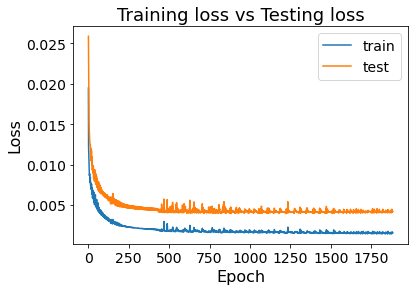

In [29]:
lr = 0.0001
EPOCHS = 3000

# initial_learning_rate * decay_rate ^ (step / decay_steps)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)

model_rnn.compile(
    optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
#               optimizer=Adam(learning_rate=lr_schedule), 
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])


es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
mc = ModelCheckpoint('saved_model/rnn_shift_anyday_6h_cp6.h5', monitor='val_mae', mode='min', verbose=2, save_best_only=True)


history = model_rnn.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=False,
                       callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [30]:
from tensorflow.keras.models import load_model
saved_model = load_model('saved_model/rnn_shift_anyday_6h_cp6.h5')

In [31]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

error = inv_yhat - inv_y
print(error.shape)

inv_y.shape, inv_yhat.shape (8745, 6) (8745, 6)
(8745, 6)


In [32]:
### check out results here
print('MAE = {}'.format(float("{:.3f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.3f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 23.951
RMSE = 40.601
